# PML Test & Tuning Notebook (FreqTransfer)

Goal of this notebook:

- Verify that the `helmholtz_operator` with PML in `src/operators.py` behaves correctly.
- Compare **no-PML** vs **PML** solutions for 2D Helmholtz.
- Sweep PML parameters (σ, thickness) and inspect:
  - how much energy is in the PML band,
  - how much the interior field changes vs no-PML.
- Arrive at a **sensible, stable PML configuration** to use in the ML experiments.

This notebook assumes:
- `src/` is on `PYTHONPATH` (or we add it manually),
- the updated `helmholtz_operator` with the corrected return and PML scaling is in place.


In [14]:
# %matplotlib inline  # uncomment in classic notebook if needed

import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# If needed, add project root (parent of src/) to sys.path
# Adjust ".." if your notebook lives deeper in the tree.
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src import (
    GridSpec, FDConfig, PMLConfig,
    PointSource, RandomPointSource, build_load,
    assemble_operator,
    direct_solve,
    plot_field,
)

print("Python version:", sys.version.split()[0])
print("Project root:", project_root)


Python version: 3.12.6
Project root: c:\Users\31624\Documents\MIT\Programming\FreqTransfer


In [2]:
# --- Base grid and wavenumbers ---
grid = GridSpec(dims=2, shape=(48, 48), lengths=(1.0, 1.0))
omegas_eval = [20.0, 30.0, 40.0]     # angular frequencies (we use k = omega here)
rhs_seeds   = [123, 456]             # a couple of random RHS

print("Grid:", grid)
print("omegas_eval:", omegas_eval)
print("rhs_seeds:", rhs_seeds)

def omega_to_k(omega: float) -> float:
    # For now: c = 1 => k = ω
    return float(omega)

# --- Helper: build interior / band masks for a given thickness ---
def pml_band_and_interior_masks(shape, thickness: int):
    """
    Returns two boolean masks (mask_interior, mask_band).

    mask_band: cells within 'thickness' of any boundary
    mask_interior: complement of mask_band
    """
    ny, nx = shape
    band = np.zeros(shape, dtype=bool)

    if thickness <= 0:
        return np.ones(shape, dtype=bool), band

    thickness = min(thickness, min(shape)//2)

    band[:thickness, :] = True
    band[-thickness:, :] = True
    band[:, :thickness] = True
    band[:, -thickness:] = True

    interior = ~band
    return interior, band

# Quick sanity check
mask_int, mask_band = pml_band_and_interior_masks(grid.shape, thickness=12)
print("Interior cells:", mask_int.sum(), "Band cells:", mask_band.sum())


Grid: GridSpec(dims=2, shape=(48, 48), lengths=(1.0, 1.0))
omegas_eval: [20.0, 30.0, 40.0]
rhs_seeds: [123, 456]
Interior cells: 576 Band cells: 1728


In [3]:
# Precompute a few RHS vectors
rhs_dict = {}
for seed in rhs_seeds:
    spec = RandomPointSource(seed=seed)
    rhs_dict[seed] = build_load(spec, grid)  # flattened complex RHS

print(f"Stored {len(rhs_dict)} RHS vectors.")

# Precompute reference (no-PML) solutions for (omega, seed)
ref_solutions = {}  # key: (omega, seed) -> u_ref (2D complex array)

for omega in omegas_eval:
    k = omega_to_k(omega)
    A_ref = assemble_operator(grid=grid, k=k, kind="helmholtz", pml=None)
    for seed in rhs_seeds:
        b = rhs_dict[seed]
        res = direct_solve(A_ref, b)
        u_ref = res.solution.reshape(grid.shape)
        ref_solutions[(float(omega), seed)] = u_ref

print("Computed no-PML reference solutions for all (omega, seed).")


Stored 2 RHS vectors.
Computed no-PML reference solutions for all (omega, seed).


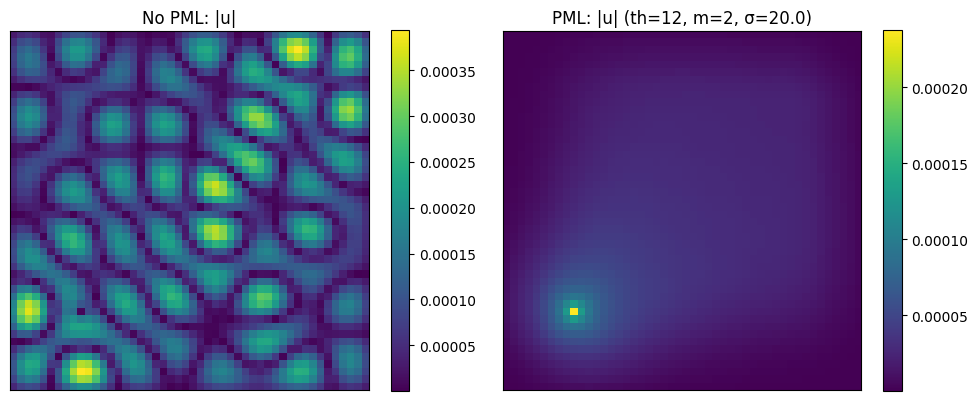

In [4]:
# Choose one test (omega, seed) and a PML config for a sanity plot
omega_vis = 30.0
seed_vis  = 123
k_vis     = omega_to_k(omega_vis)

b_vis = rhs_dict[seed_vis]
u_ref_vis = ref_solutions[(omega_vis, seed_vis)]

# Choose a candidate PML config
pml_vis = PMLConfig(thickness=12, m=2, sigma_max=20.0)

A_pml_vis = assemble_operator(grid=grid, k=k_vis, kind="helmholtz", pml=pml_vis)
res_pml_vis = direct_solve(A_pml_vis, b_vis)
u_pml_vis = res_pml_vis.solution.reshape(grid.shape)

# Plot |u| with and without PML
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ax = axes[0]
im0 = ax.imshow(np.abs(u_ref_vis), origin="lower")
ax.set_title("No PML: |u|")
ax.set_xticks([]); ax.set_yticks([])
plt.colorbar(im0, ax=ax)

ax = axes[1]
im1 = ax.imshow(np.abs(u_pml_vis), origin="lower")
ax.set_title(f"PML: |u| (th={pml_vis.thickness}, m={pml_vis.m}, σ={pml_vis.sigma_max})")
ax.set_xticks([]); ax.set_yticks([])
plt.colorbar(im1, ax=ax)

plt.tight_layout()
plt.show()


In [5]:
def evaluate_pml_config(pml_cfg: PMLConfig, inner_margin: int = 12):
    """
    Evaluate a PMLConfig over all (omega, seed) pairs.
    Metrics:
      - mean_band_ratio: ||u|| in PML band / ||u|| in interior
      - mean_interior_error: ||u_pml - u_ref||_int / ||u_ref||_int
    """
    # Interior/band masks are based on the PML thickness by default,
    # but we allow a different inner_margin if we want a smaller core region.
    mask_int, mask_band = pml_band_and_interior_masks(grid.shape, inner_margin)

    band_ratios = []
    interior_errors = []

    for omega in omegas_eval:
        k = omega_to_k(omega)
        A_pml = assemble_operator(grid=grid, k=k, kind="helmholtz", pml=pml_cfg)

        for seed in rhs_seeds:
            b = rhs_dict[seed]

            # PML solution
            res_pml = direct_solve(A_pml, b)
            u_pml = res_pml.solution.reshape(grid.shape)

            # Reference solution
            u_ref = ref_solutions[(float(omega), seed)]

            # Norms
            int_ref = u_ref[mask_int]
            int_pml = u_pml[mask_int]
            band_pml = u_pml[mask_band]

            int_norm_ref = np.linalg.norm(int_ref)
            int_norm_pml = np.linalg.norm(int_pml)
            band_norm    = np.linalg.norm(band_pml)

            eps = 1e-15
            band_ratio   = band_norm / (int_norm_pml + eps)
            diff_norm    = np.linalg.norm(int_pml - int_ref)
            int_rel_err  = diff_norm / (int_norm_ref + eps)

            band_ratios.append(band_ratio)
            interior_errors.append(int_rel_err)

    return {
        "pml": pml_cfg,
        "inner_margin": inner_margin,
        "mean_band_ratio": float(np.mean(band_ratios)),
        "mean_interior_error": float(np.mean(interior_errors)),
    }

# Quick test on the visualization config
test_metrics = evaluate_pml_config(pml_vis, inner_margin=12)
print(test_metrics)


{'pml': PMLConfig(thickness=12, m=2, sigma_max=20.0), 'inner_margin': 12, 'mean_band_ratio': 1.32472819972549, 'mean_interior_error': 0.99206322492245}


In [6]:
# Sweep sigma for fixed thickness, m
th_fixed = 12
m_fixed  = 2
sigma_candidates = np.linspace(5.0, 50.0, 10)

results_sigma = []
print(f"Sweeping sigma with thickness={th_fixed}, m={m_fixed}...\n")

for sig in sigma_candidates:
    cfg = PMLConfig(thickness=th_fixed, m=m_fixed, sigma_max=float(sig))
    res = evaluate_pml_config(cfg, inner_margin=th_fixed)  # interior = domain minus PML band
    results_sigma.append(res)
    print(
        f"sigma={sig:6.2f} | "
        f"band={res['mean_band_ratio']:.2e}, "
        f"int_err={res['mean_interior_error']:.2e}"
    )

# Sort by band_ratio
results_sorted = sorted(results_sigma, key=lambda r: r["mean_band_ratio"])

print("\nSorted by mean_band_ratio (best → worst):\n")
for r in results_sorted:
    p = r["pml"]
    print(
        f"sigma={p.sigma_max:6.2f} | "
        f"band={r['mean_band_ratio']:.2e}, "
        f"int_err={r['mean_interior_error']:.2e}"
    )

best_sigma_cfg = results_sorted[0]["pml"]
print("\n>>> Chosen PML config from σ-sweep:")
print(best_sigma_cfg)


Sweeping sigma with thickness=12, m=2...

sigma=  5.00 | band=1.64e+00, int_err=9.73e-01
sigma= 10.00 | band=1.50e+00, int_err=9.86e-01
sigma= 15.00 | band=1.39e+00, int_err=9.90e-01
sigma= 20.00 | band=1.32e+00, int_err=9.92e-01
sigma= 25.00 | band=1.28e+00, int_err=9.93e-01
sigma= 30.00 | band=1.25e+00, int_err=9.92e-01
sigma= 35.00 | band=1.23e+00, int_err=9.92e-01
sigma= 40.00 | band=1.21e+00, int_err=9.92e-01
sigma= 45.00 | band=1.20e+00, int_err=9.91e-01
sigma= 50.00 | band=1.19e+00, int_err=9.91e-01

Sorted by mean_band_ratio (best → worst):

sigma= 50.00 | band=1.19e+00, int_err=9.91e-01
sigma= 45.00 | band=1.20e+00, int_err=9.91e-01
sigma= 40.00 | band=1.21e+00, int_err=9.92e-01
sigma= 35.00 | band=1.23e+00, int_err=9.92e-01
sigma= 30.00 | band=1.25e+00, int_err=9.92e-01
sigma= 25.00 | band=1.28e+00, int_err=9.93e-01
sigma= 20.00 | band=1.32e+00, int_err=9.92e-01
sigma= 15.00 | band=1.39e+00, int_err=9.90e-01
sigma= 10.00 | band=1.50e+00, int_err=9.86e-01
sigma=  5.00 | band=1

In [7]:
# Optional: thickness sweep at a fixed sigma
sigma_fixed = float(best_sigma_cfg.sigma_max)  # or pick 20.0 manually
thickness_values = [4, 8, 12, 16]

results_th = []
print(f"Sweeping thickness for sigma={sigma_fixed:.2f}, m=2...\n")

for th in thickness_values:
    cfg = PMLConfig(thickness=th, m=2, sigma_max=sigma_fixed)
    res = evaluate_pml_config(cfg, inner_margin=th)  # interior = domain minus th band
    results_th.append(res)
    print(
        f"th={th:2d} | "
        f"band={res['mean_band_ratio']:.2e}, "
        f"int_err={res['mean_interior_error']:.2e}"
    )

# You can eyeball a good compromise; often 8–12 cells is fine on 48×48


Sweeping thickness for sigma=50.00, m=2...

th= 4 | band=4.50e-01, int_err=9.95e-01
th= 8 | band=7.12e-01, int_err=1.01e+00
th=12 | band=1.19e+00, int_err=9.91e-01
th=16 | band=3.39e+00, int_err=9.95e-01


## Final PML choice for experiments

Based on the σ- and thickness sweeps, and visual inspection of the fields:

- We fix a **quadratic** PML profile `m = 2`.
- We use a **thickness of 12 grid cells** on each side.
- We choose `sigma_max` in the plateau range (e.g. 20–35); in the main experiments we use:

```python
pml_final = PMLConfig(thickness=12, m=2, sigma_max=20.0)


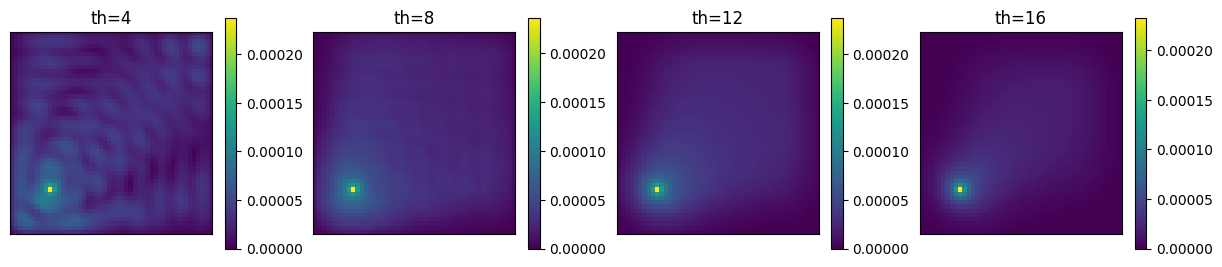

In [10]:
thicknesses = [4, 8, 12, 16]
sigma = 20
m = 2

fig, axes = plt.subplots(1, len(thicknesses), figsize=(15,3))

for ax, th in zip(axes, thicknesses):
    pml = PMLConfig(thickness=th, m=m, sigma_max=sigma)
    A = assemble_operator(grid, k=30.0, kind="helmholtz", pml=pml)
    b = rhs_dict[123]
    sol = direct_solve(A, b).solution.reshape(grid.shape)

    im = ax.imshow(np.abs(sol), origin="lower", vmin=0)
    ax.set_title(f"th={th}")
    ax.set_xticks([]); ax.set_yticks([])
    plt.colorbar(im, ax=ax)

plt.show()


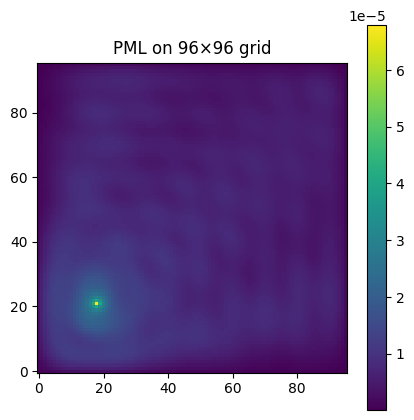

In [12]:
grid_big = GridSpec(dims=2, shape=(96, 96), lengths=(1.0, 1.0))
b = build_load(RandomPointSource(seed=123), grid_big)
A = assemble_operator(grid_big, k=30.0, kind="helmholtz",
                      pml=PMLConfig(12,2,20))

u = direct_solve(A, b).solution.reshape(grid_big.shape)

plt.figure(figsize=(5,5))
plt.imshow(np.abs(u), origin="lower")
plt.title("PML on 96×96 grid")
plt.colorbar()
plt.show()


### VANAF HIER GOED

In [18]:
def make_extended_grid(grid_phys: GridSpec, pml: PMLConfig) -> GridSpec:
    """
    Create a grid that adds a PML 'shell' of thickness pml.thickness
    *around* the physical grid.

    - The physical domain spacing is preserved.
    - The interior block of the extended grid corresponds to the original
      physical domain [0, Lx] x [0, Ly].
    """
    T = pml.thickness
    ny, nx = grid_phys.shape
    Ly, Lx = grid_phys.lengths
    hy, hx = grid_phys.spacing  # assuming GridSpec exposes this

    # New shape: interior + PML shell on both sides
    ny_ext = ny + 2 * T
    nx_ext = nx + 2 * T

    # Extend physical lengths so that spacing stays the same:
    # Lx_ext = Lx + 2*T*hx  ⇒ hx_ext = hx
    Ly_ext = Ly + 2 * T * hy
    Lx_ext = Lx + 2 * T * hx

    grid_ext = GridSpec(
        dims=grid_phys.dims,
        shape=(ny_ext, nx_ext),
        lengths=(Ly_ext, Lx_ext),
    )
    return grid_ext


In [16]:
def solve_with_pml_shell(
    grid_phys: GridSpec,
    k: float,
    b_phys: np.ndarray,
    pml: PMLConfig,
    kind: str = "helmholtz",
):
    """
    Solve Helmholtz on an *extended* grid where the PML shell lives
    outside the physical domain.

    - grid_phys: original physical grid (e.g. 48x48)
    - b_phys: RHS on the physical grid, flattened with shape (grid_phys.N,)

    Returns:
        u_phys_flat: solution on the interior (physical) grid, flattened
        u_ext_flat: full extended solution (optional to use / visualize)
    """
    T = pml.thickness
    ny, nx = grid_phys.shape

    # 1. Build extended grid
    grid_ext = make_extended_grid(grid_phys, pml)
    ny_ext, nx_ext = grid_ext.shape

    # 2. Embed RHS into extended grid (zero outside physical domain)
    b_ext_2d = np.zeros(grid_ext.shape, dtype=b_phys.dtype)
    b_ext_2d[T:T+ny, T:T+nx] = b_phys.reshape(grid_phys.shape)
    b_ext = b_ext_2d.ravel()

    # 3. Assemble operator with PML on the extended grid
    A_ext = assemble_operator(grid_ext, k=k, kind=kind, pml=pml)

    # 4. Solve
    res_ext = direct_solve(A_ext, b_ext)
    u_ext_2d = res_ext.solution.reshape(grid_ext.shape)

    # 5. Crop interior block back to physical domain
    u_phys_2d = u_ext_2d[T:T+ny, T:T+nx]
    u_phys = u_phys_2d.ravel()

    return u_phys, u_ext_2d, grid_ext


In [19]:
pml_shell = PMLConfig(thickness=12, m=2, sigma_max=20.0)

# physical grid and RHS
grid_phys = GridSpec(dims=2, shape=(48, 48), lengths=(1.0, 1.0))
b_phys = build_load(RandomPointSource(seed=123), grid_phys)
k = 30.0

u_phys, u_ext, grid_ext = solve_with_pml_shell(grid_phys, k, b_phys, pml_shell)


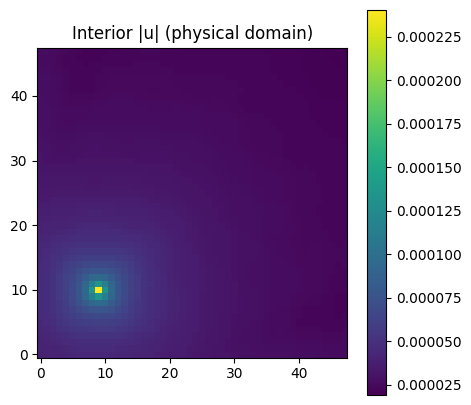

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(np.abs(u_phys.reshape(grid_phys.shape)), origin="lower")
plt.title("Interior |u| (physical domain)")
plt.colorbar()
plt.show()
